# Statistical analysis of pore network simulation

## Setup and Imports

First, we import the necessary Python libraries and set up our plotting style for a clean, scientific look. We also define the path to the simulation output directory.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

USE_PBC = False           # Set to True for PBC, False for Non-PBC
USE_RANDOMIZED = False   # Set to True for Randomized weights (02), False for Real (01)

# Construct the directory name automatically based on flags
base_name = "output"
if USE_PBC:
    base_name += "_PBC"

if not USE_RANDOMIZED:
    base_name += "_01"
else:
    base_name += "_02"

OUTPUT_DIR = base_name + "/"

print(f"CURRENTLY ANALYZING DIRECTORY: {OUTPUT_DIR}")


# Set plotting style
plt.style.use('seaborn-v0_8-notebook')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

CURRENTLY ANALYZING DIRECTORY: output_01/


## Helper functions

We define some helper functions to load the different types of data files our C++ code produces. This keeps the rest of the notebook clean.

In [ ]:
# Helper Functions (Updated for Path flexibility) 

def load_histogram(filename, path=OUTPUT_DIR):
    """Loads a 3-column histogram file (index, center, value)."""
    filepath = os.path.join(path, filename)
    try:
        data = pd.read_csv(filepath, sep='\t', header=None, comment='#',
                           usecols=[1, 2], names=['q', 'P(q)'], engine='python')
        return data[data['P(q)'] > 0].reset_index(drop=True)
    except: return None

def load_k_data(filename, path=OUTPUT_DIR):
    """Loads a 3-column k-dependent file (k, value, error)."""
    filepath = os.path.join(path, filename)
    try:
        return pd.read_csv(filepath, sep='\t', header=None, comment='#',
                           names=['k', 'value', 'error'], engine='python')
    except: return None

def load_analytical_fit(filename, path=OUTPUT_DIR):
    """Loads a 2-column analytical fit file."""
    filepath = os.path.join(path, filename)
    try:
        data = pd.read_csv(filepath, sep=r'\s+', comment='#',
                           header=None, names=['q', 'P(q)'])
        return data[data['P(q)'] > 0].reset_index(drop=True)
    except: return None

def load_coords(filename, path=OUTPUT_DIR):
    filepath = os.path.join(path, filename)
    try:
        return pd.read_csv(filepath, sep=' ', header=None, usecols=[0, 1, 2],
                           names=['id', 'x', 'y'])
    except: return None

def load_layers_data(filename, path=OUTPUT_DIR):
    filepath = os.path.join(path, filename)
    try:
        return pd.read_csv(filepath, sep=' ', engine='python')
    except: return None

def load_layer_stats(filename, path=OUTPUT_DIR):
    filepath = os.path.join(path, filename)
    try:
        return pd.read_csv(filepath, sep='\t', comment='#', header=None,
                           names=['dist', 'cv_mass', 'cv_evenness', 'mean_mass', 'mean_evenness'],
                           engine='python')
    except: return None

## Flow distributions (simulation vs. analytical)

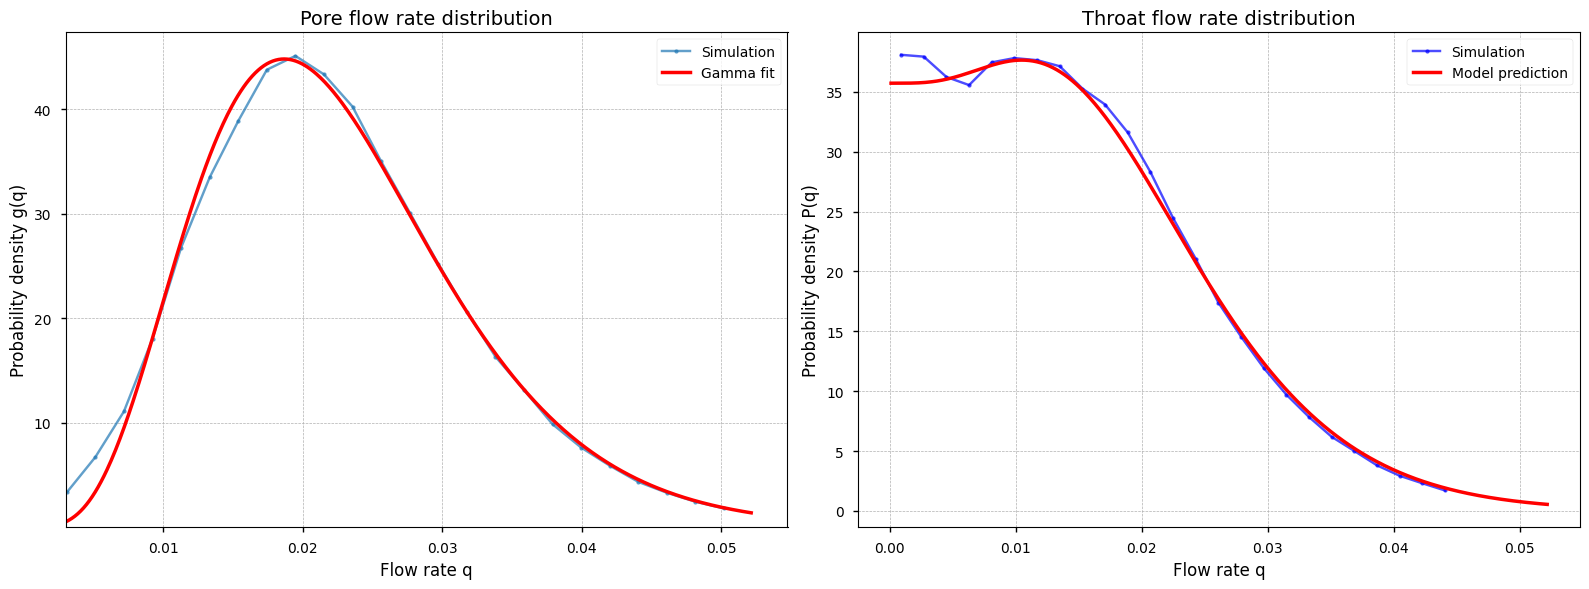

In [ ]:
# Load all the necessary data
pore_dist = load_histogram("pore_flow_dist.dat")
tube_dist = load_histogram("tube_flow_dist.dat")
fit_P = load_analytical_fit("analytical_P_fit.dat")
fit_g = load_analytical_fit("analytical_g_fit.dat")
fit_f = load_analytical_fit("analytical_f_fit.dat") # This is loaded but not used in this cell


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Pore Distribution vs. g(q) Fit
if pore_dist is not None and fit_g is not None:
    ax1.plot(pore_dist['q'], pore_dist['P(q)'], 'o-', markersize=3, 
             label='Simulation', alpha=0.7)
    
    ax1.plot(fit_g['q'], fit_g['P(q)'], 'r-', linewidth=2.5, 
             label='Gamma fit')
    
    ax1.set_title('Pore flow rate distribution')
    ax1.set_xlabel('Flow rate q')
    ax1.set_ylabel('Probability density g(q)')
    #ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True, which="both", ls="--", lw=0.5)
    ax1.set_xlim(left=0.003)
    ax1.set_ylim(bottom=0.01)
else:
    ax1.set_title("Pore/g(q) data not found")
    print("Skipping Pore vs. g(q) plot: data files not found.")

# Plot 2: Tube Distribution vs. P(q) fit 
if tube_dist is not None and fit_P is not None:
    ax2.plot(tube_dist['q'], tube_dist['P(q)'], 'o-', markersize=3, 
             label='Simulation', alpha=0.7, color='blue')
    
    ax2.plot(fit_P['q'], fit_P['P(q)'], 'r-', linewidth=2.5, 
             label='Model prediction')
    
    ax2.set_title('Throat flow rate distribution')
    ax2.set_xlabel('Flow rate q')
    ax2.set_ylabel('Probability density P(q)')
    #ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, which="both", ls="--", lw=0.5)
else:
    ax2.set_title("Tube/P(q) data not found")
    print("Skipping Tube vs. P(q) plot: data files not found.")

plt.tight_layout()
plt.show()

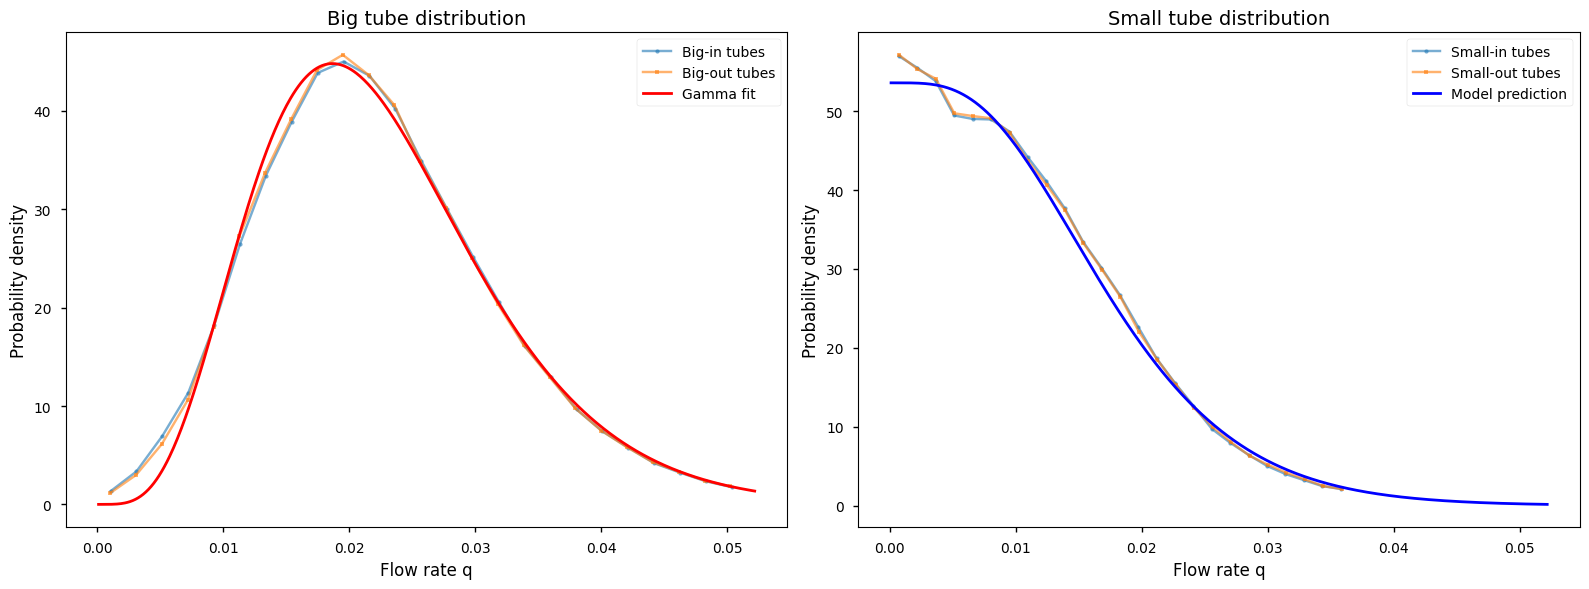

In [ ]:
# Load sub-population data
big_in_dist = load_histogram("big_in_tube_flow_dist.dat")
big_out_dist = load_histogram("big_out_tube_flow_dist.dat")
small_in_dist = load_histogram("small_in_tube_flow_dist.dat")
small_out_dist = load_histogram("small_out_tube_flow_dist.dat")
pore1_dist = load_histogram("pore_1_flow_dist.dat")
pore2_dist = load_histogram("pore_2_flow_dist.dat")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


# Plot 1: Big/Pore vs. g(q)
if big_in_dist is not None:
    ax1.plot(big_in_dist['q'], big_in_dist['P(q)'], 'o-', markersize=3, label='Big-in tubes', alpha=0.6)
if big_out_dist is not None:
    ax1.plot(big_out_dist['q'], big_out_dist['P(q)'], 's-', markersize=3, label='Big-out tubes', alpha=0.6)
if fit_g is not None:
    ax1.plot(fit_g['q'], fit_g['P(q)'], 'r-', lw=2, label='Gamma fit')
ax1.set_title('Big tube distribution')
ax1.set_xlabel('Flow rate q')
ax1.set_ylabel('Probability density')
#ax1.set_yscale('log')
ax1.legend()

# Plot 2: Small vs. f(q)
if small_in_dist is not None:
    ax2.plot(small_in_dist['q'], small_in_dist['P(q)'], 'o-', markersize=3, label='Small-in tubes', alpha=0.6)
if small_out_dist is not None:
    ax2.plot(small_out_dist['q'], small_out_dist['P(q)'], 's-', markersize=3, label='Small-out tubes', alpha=0.6)
if fit_f is not None:
    ax2.plot(fit_f['q'], fit_f['P(q)'], 'b-', lw=2, label='Model prediction')
ax2.set_title('Small tube distribution')
ax2.set_xlabel('Flow rate q')
ax2.set_ylabel('Probability density')
#ax2.set_yscale('log')
ax2.legend()

plt.tight_layout()
plt.show()

## Spatial correlations

Here we plot the summary statistics collected from the k-analysis loop. We are looking at how correlations (mass, evenness) evolve with distance `D`.

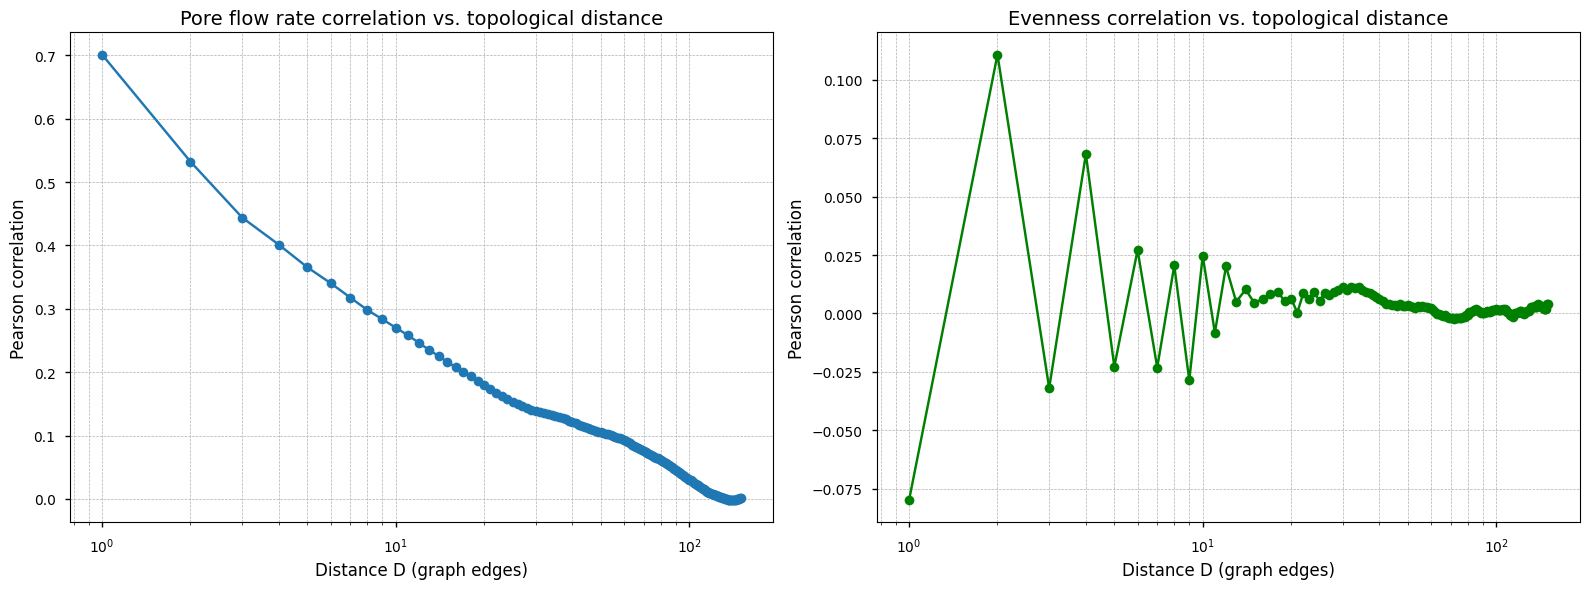

In [219]:
corr_mass_data = load_k_data("k_corr_mass.dat")
corr_evenness_data = load_k_data("k_corr_evenness.dat")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Mass Correlation vs. k
if corr_mass_data is not None:
    ax1.plot(corr_mass_data['k'], corr_mass_data['value'], 'o-')
    ax1.set_title('Pore flow rate correlation vs. topological distance')
    ax1.set_xlabel('Distance D (graph edges)')
    ax1.set_ylabel('Pearson correlation')
    ax1.set_xscale('log')
    #ax1.set_yscale('log')
    ax1.grid(True, which="both", ls="--", lw=0.5)
else:
    ax1.set_title('Mass Correlation Data Not Found')

# Plot 2: Evenness Correlation vs. k
if corr_evenness_data is not None:
    ax2.plot(corr_evenness_data['k'], corr_evenness_data['value'], 'o-', color='green')
    ax2.set_title('Evenness correlation vs. topological distance')
    ax2.set_xlabel('Distance D (graph edges)')
    ax2.set_ylabel('Pearson correlation')
    ax2.set_xscale('log')
    # --- MODIFIED: Removed xticks and xticklabels to prevent overlap ---
    ax2.grid(True, which="both", ls="--", lw=0.5)
else:
    ax2.set_title('Evenness Correlation Data Not Found')

plt.tight_layout()
plt.show()

## Average degree of order D

Here we plot the average D-th order degrees (exact and cumulative) as a function of topological distance `D`.

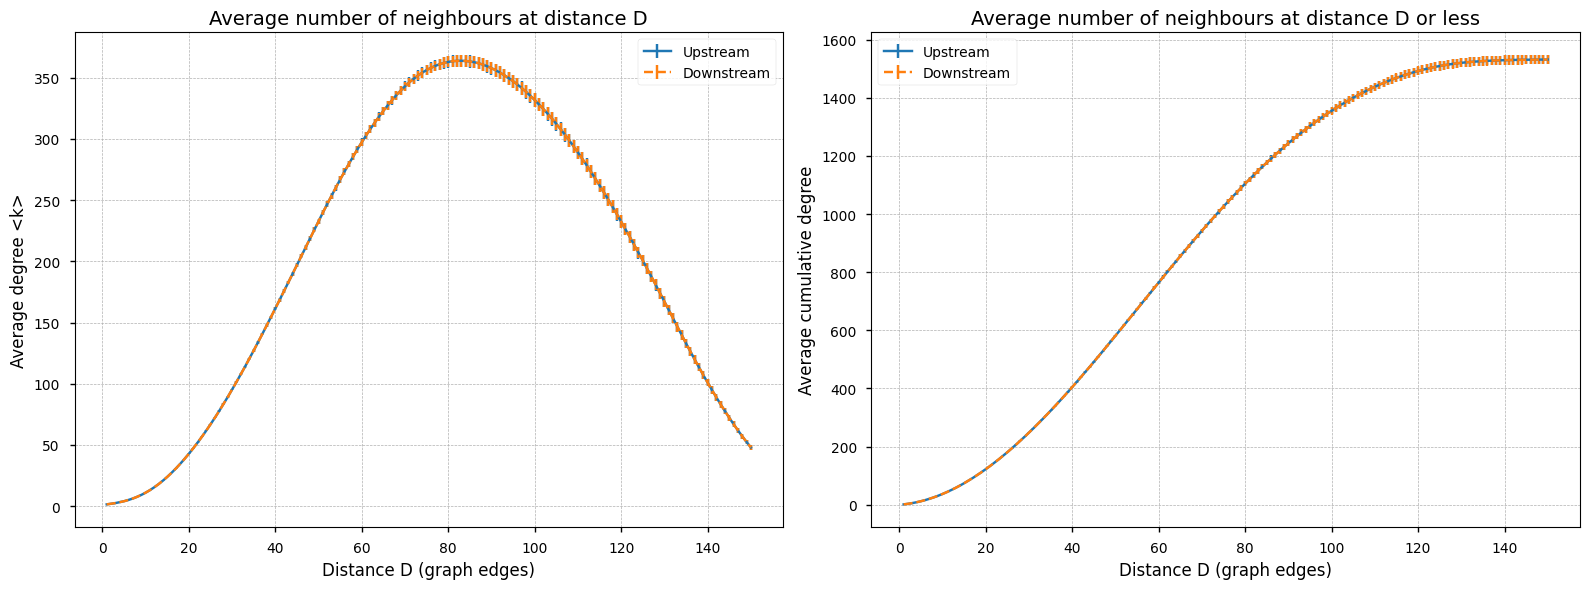

In [220]:
avg_in_deg = load_k_data("k_avg_in_degree.dat")
avg_out_deg = load_k_data("k_avg_out_degree.dat")
avg_cum_in_deg = load_k_data("k_avg_CUM_in_degree.dat")
avg_cum_out_deg = load_k_data("k_avg_CUM_out_degree.dat")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


# Plot 1: Exact D-th order degree vs. D
if avg_in_deg is not None and avg_out_deg is not None:
    ax1.errorbar(avg_in_deg['k'], avg_in_deg['value'], yerr=avg_in_deg['error'], 
                 fmt='-', capsize=5, label='Upstream')
    ax1.errorbar(avg_out_deg['k'], avg_out_deg['value'], yerr=avg_out_deg['error'], 
                 fmt='--', capsize=5, label='Downstream')
    ax1.set_title('Average number of neighbours at distance D')
    ax1.set_xlabel('Distance D (graph edges)')
    ax1.set_ylabel('Average degree <k>')
    #ax1.set_xscale('log', base=2)
    #ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True, which="both", ls="--", lw=0.5)
else:
    ax1.set_title('Exact Degree Data Not Found')

# Plot 2: Cumulative k-th Order Degree vs. k
if avg_cum_in_deg is not None and avg_cum_out_deg is not None:
    ax2.errorbar(avg_cum_in_deg['k'], avg_cum_in_deg['value'], yerr=avg_cum_in_deg['error'], 
                 fmt='-', capsize=5, label='Upstream')
    ax2.errorbar(avg_cum_out_deg['k'], avg_cum_out_deg['value'], yerr=avg_cum_out_deg['error'], 
                 fmt='--', capsize=5, label='Downstream')
    ax2.set_title('Average number of neighbours at distance D or less')
    ax2.set_xlabel('Distance D (graph edges)')
    ax2.set_ylabel('Average cumulative degree')
    #ax2.set_xscale('log', base=10)
    #ax2.set_yscale('log')
    # --- MODIFIED: Removed xticks and xticklabels ---
    ax2.legend()
    ax2.grid(True, which="both", ls="--", lw=0.5)
else:
    ax2.set_title('Cumulative Degree Data Not Found')

plt.tight_layout()
plt.show()

## Distribution of degree and splitting fraction of order D

Loading and plotting k-dependent distributions...
  Plotting for D=1...
  Plotting for D=2...
  Plotting for D=3...
  Plotting for D=4...
  Plotting for D=5...


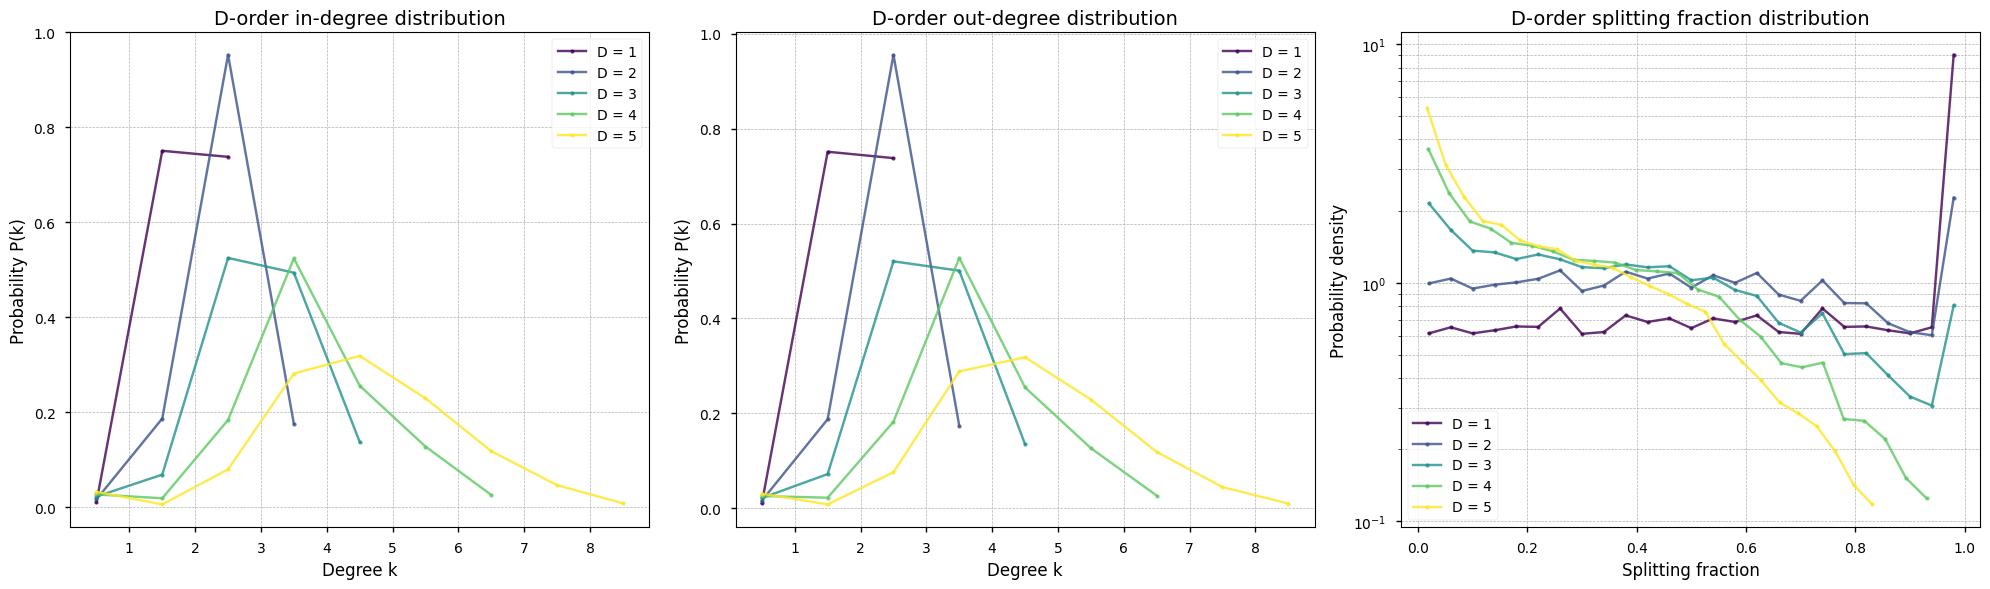

Plotting complete.


In [221]:
# --- 1. Define Representative k-Values to Plot ---
# Based on the peak at k=80, we select values to show
# the "rise", "peak", and "fall" of the distributions.
k_to_plot = [1, 2, 3, 4, 5]

# Create the figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Generate a color map to make k-values distinct
colors = plt.cm.viridis(np.linspace(0, 1, len(k_to_plot)))

print("Loading and plotting k-dependent distributions...")
for i, k in enumerate(k_to_plot):
    color = colors[i]
    label = f'D = {k}'
    print(f"  Plotting for D={k}...")
    
    # --- Plot 1: k-Order In-Degree ---
    file_in = f"order_k_in_degree_k={k}.dat"
    data_in = load_histogram(file_in) # Assumes load_histogram is defined
    if data_in is not None:
        # 'q' is degree, 'P(q)' is probability
        ax1.plot(data_in['q'], data_in['P(q)'], 'o-', label=label, color=color, markersize=3, alpha=0.8)

    # --- Plot 2: k-Order Out-Degree ---
    file_out = f"order_k_out_degree_k={k}.dat"
    data_out = load_histogram(file_out)
    if data_out is not None:
        ax2.plot(data_out['q'], data_out['P(q)'], 'o-', label=label, color=color, markersize=3, alpha=0.8)

    # --- Plot 3: T-Fractions (Path Weights) ---
    file_t = f"t_fractions_dist_k={k}.dat"
    data_t = load_histogram(file_t)
    if data_t is not None:
        ax3.plot(data_t['q'], data_t['P(q)'], 'o-', label=label, color=color, markersize=3, alpha=0.8)

# --- 4. Set titles, scales, and legends ---

ax1.set_title("D-order in-degree distribution")
ax1.set_xlabel("Degree k")
ax1.set_ylabel("Probability P(k)")
#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, which="both", ls="--", lw=0.5)

ax2.set_title("D-order out-degree distribution")
ax2.set_xlabel("Degree k")
ax2.set_ylabel("Probability P(k)")
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, which="both", ls="--", lw=0.5)

ax3.set_title("D-order splitting fraction distribution")
ax3.set_xlabel("Splitting fraction")
ax3.set_ylabel("Probability density")
ax3.set_yscale('log') # log-lin is usually best for weights
ax3.legend()
ax3.grid(True, which="both", ls="--", lw=0.5)

plt.tight_layout()
plt.show()
print("Plotting complete.")

Loading and plotting k-dependent distributions...
  Plotting for D=6...
  Plotting for D=7...
  Plotting for D=8...
  Plotting for D=9...
  Plotting for D=10...


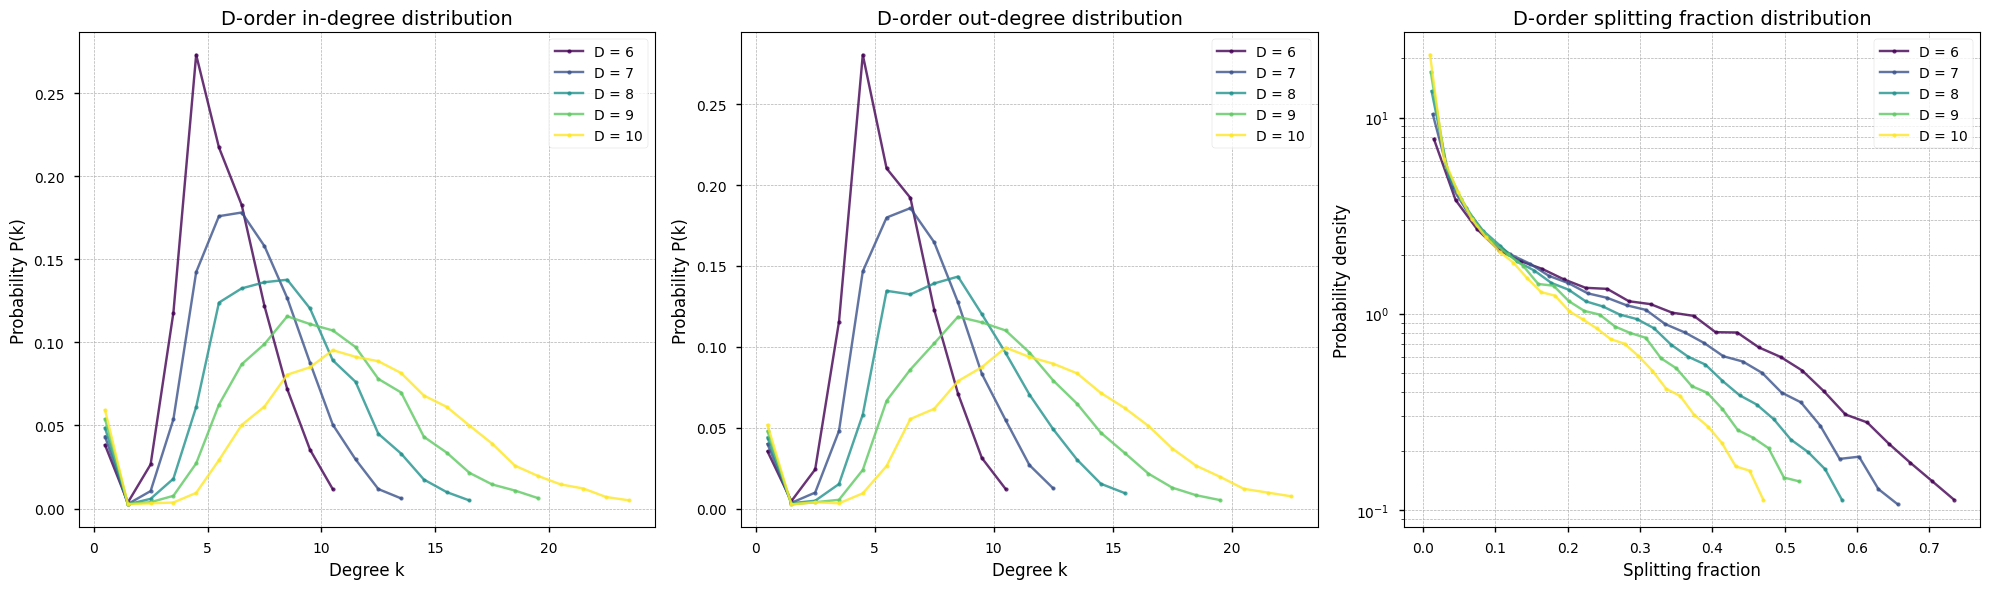

Plotting complete.


In [222]:
k_to_plot = [6, 7, 8, 9, 10]

# Create the figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Generate a color map to make k-values distinct
colors = plt.cm.viridis(np.linspace(0, 1, len(k_to_plot)))

print("Loading and plotting k-dependent distributions...")
for i, k in enumerate(k_to_plot):
    color = colors[i]
    label = f'D = {k}'
    print(f"  Plotting for D={k}...")
    
    # --- Plot 1: k-Order In-Degree ---
    file_in = f"order_k_in_degree_k={k}.dat"
    data_in = load_histogram(file_in) # Assumes load_histogram is defined
    if data_in is not None:
        # 'q' is degree, 'P(q)' is probability
        ax1.plot(data_in['q'], data_in['P(q)'], 'o-', label=label, color=color, markersize=3, alpha=0.8)

    # --- Plot 2: k-Order Out-Degree ---
    file_out = f"order_k_out_degree_k={k}.dat"
    data_out = load_histogram(file_out)
    if data_out is not None:
        ax2.plot(data_out['q'], data_out['P(q)'], 'o-', label=label, color=color, markersize=3, alpha=0.8)

    # --- Plot 3: T-Fractions (Path Weights) ---
    file_t = f"t_fractions_dist_k={k}.dat"
    data_t = load_histogram(file_t)
    if data_t is not None:
        ax3.plot(data_t['q'], data_t['P(q)'], 'o-', label=label, color=color, markersize=3, alpha=0.8)

# --- 4. Set titles, scales, and legends ---

ax1.set_title("D-order in-degree distribution")
ax1.set_xlabel("Degree k")
ax1.set_ylabel("Probability P(k)")
#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, which="both", ls="--", lw=0.5)

ax2.set_title("D-order out-degree distribution")
ax2.set_xlabel("Degree k")
ax2.set_ylabel("Probability P(k)")
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, which="both", ls="--", lw=0.5)

ax3.set_title("D-order splitting fraction distribution")
ax3.set_xlabel("Splitting fraction")
ax3.set_ylabel("Probability density")
ax3.set_yscale('log') # log-lin is usually best for weights
ax3.legend()
ax3.grid(True, which="both", ls="--", lw=0.5)

plt.tight_layout()
plt.show()
print("Plotting complete.")

Loading and plotting k-dependent distributions...
  Plotting for D=70...
  Plotting for D=75...
  Plotting for D=80...
  Plotting for D=85...
  Plotting for D=90...


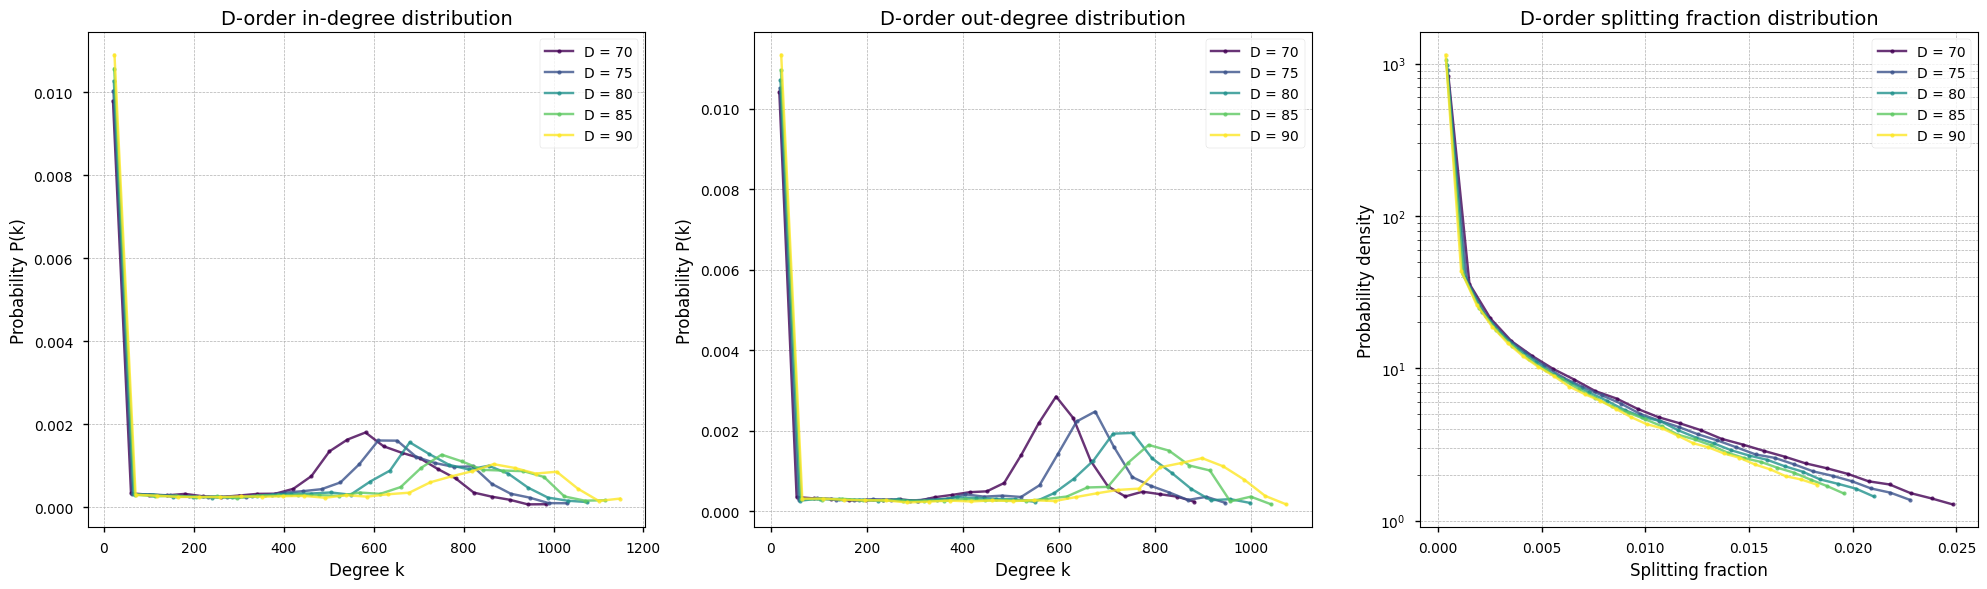

Plotting complete.


In [223]:
k_to_plot = [70, 75, 80, 85, 90]

# Create the figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Generate a color map to make k-values distinct
colors = plt.cm.viridis(np.linspace(0, 1, len(k_to_plot)))

print("Loading and plotting k-dependent distributions...")
for i, k in enumerate(k_to_plot):
    color = colors[i]
    label = f'D = {k}'
    print(f"  Plotting for D={k}...")
    
    # --- Plot 1: k-Order In-Degree ---
    file_in = f"order_k_in_degree_k={k}.dat"
    data_in = load_histogram(file_in) # Assumes load_histogram is defined
    if data_in is not None:
        # 'q' is degree, 'P(q)' is probability
        ax1.plot(data_in['q'], data_in['P(q)'], 'o-', label=label, color=color, markersize=3, alpha=0.8)

    # --- Plot 2: k-Order Out-Degree ---
    file_out = f"order_k_out_degree_k={k}.dat"
    data_out = load_histogram(file_out)
    if data_out is not None:
        ax2.plot(data_out['q'], data_out['P(q)'], 'o-', label=label, color=color, markersize=3, alpha=0.8)

    # --- Plot 3: T-Fractions (Path Weights) ---
    file_t = f"t_fractions_dist_k={k}.dat"
    data_t = load_histogram(file_t)
    if data_t is not None:
        ax3.plot(data_t['q'], data_t['P(q)'], 'o-', label=label, color=color, markersize=3, alpha=0.8)

# --- 4. Set titles, scales, and legends ---

ax1.set_title("D-order in-degree distribution")
ax1.set_xlabel("Degree k")
ax1.set_ylabel("Probability P(k)")
#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, which="both", ls="--", lw=0.5)

ax2.set_title("D-order out-degree distribution")
ax2.set_xlabel("Degree k")
ax2.set_ylabel("Probability P(k)")
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, which="both", ls="--", lw=0.5)

ax3.set_title("D-order splitting fraction distribution")
ax3.set_xlabel("Splitting fraction")
ax3.set_ylabel("Probability density")
ax3.set_yscale('log') 
ax3.legend()
ax3.grid(True, which="both", ls="--", lw=0.5)

plt.tight_layout()
plt.show()
print("Plotting complete.")

Loading and plotting k-dependent distributions...
  Plotting for D=110...
  Plotting for D=120...
  Plotting for D=130...
  Plotting for D=140...
  Plotting for D=150...


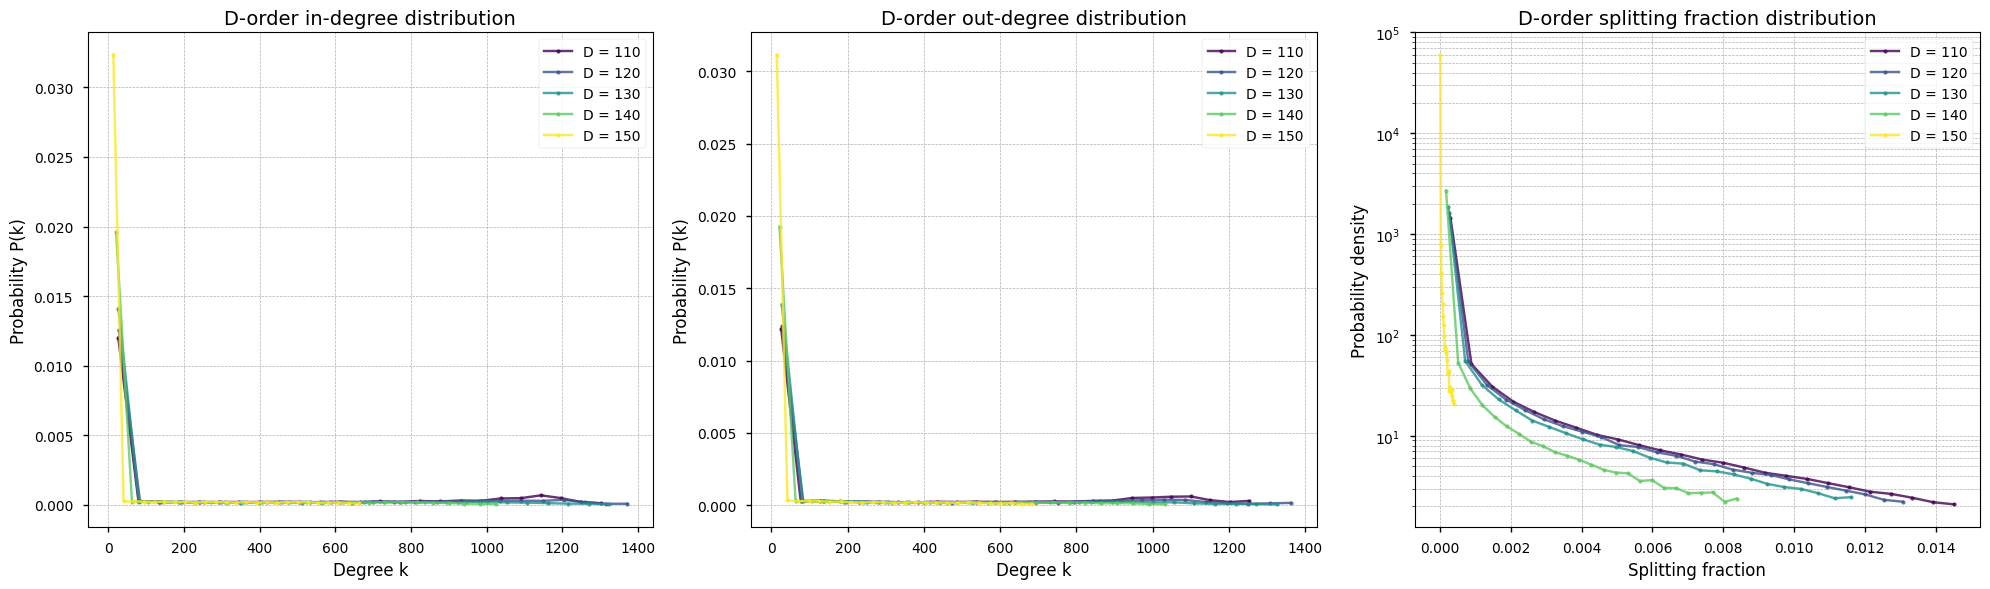

Plotting complete.


In [224]:
k_to_plot = [110, 120, 130, 140, 150]

# Create the figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Generate a color map to make k-values distinct
colors = plt.cm.viridis(np.linspace(0, 1, len(k_to_plot)))

print("Loading and plotting k-dependent distributions...")
for i, k in enumerate(k_to_plot):
    color = colors[i]
    label = f'D = {k}'
    print(f"  Plotting for D={k}...")
    
    # --- Plot 1: k-Order In-Degree ---
    file_in = f"order_k_in_degree_k={k}.dat"
    data_in = load_histogram(file_in) # Assumes load_histogram is defined
    if data_in is not None:
        # 'q' is degree, 'P(q)' is probability
        ax1.plot(data_in['q'], data_in['P(q)'], 'o-', label=label, color=color, markersize=3, alpha=0.8)

    # --- Plot 2: k-Order Out-Degree ---
    file_out = f"order_k_out_degree_k={k}.dat"
    data_out = load_histogram(file_out)
    if data_out is not None:
        ax2.plot(data_out['q'], data_out['P(q)'], 'o-', label=label, color=color, markersize=3, alpha=0.8)

    # --- Plot 3: T-Fractions (Path Weights) ---
    file_t = f"t_fractions_dist_k={k}.dat"
    data_t = load_histogram(file_t)
    if data_t is not None:
        ax3.plot(data_t['q'], data_t['P(q)'], 'o-', label=label, color=color, markersize=3, alpha=0.8)

# --- 4. Set titles, scales, and legends ---

ax1.set_title("D-order in-degree distribution")
ax1.set_xlabel("Degree k")
ax1.set_ylabel("Probability P(k)")
#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, which="both", ls="--", lw=0.5)

ax2.set_title("D-order out-degree distribution")
ax2.set_xlabel("Degree k")
ax2.set_ylabel("Probability P(k)")
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, which="both", ls="--", lw=0.5)

ax3.set_title("D-order splitting fraction distribution")
ax3.set_xlabel("Splitting fraction")
ax3.set_ylabel("Probability density")
ax3.set_yscale('log') # log-lin is usually best for weights
ax3.legend()
ax3.grid(True, which="both", ls="--", lw=0.5)

plt.tight_layout()
plt.show()
print("Plotting complete.")

## Evenness and splitting fraction distribution

Plots for the evenness of splitters and the fraction of weights on the links.

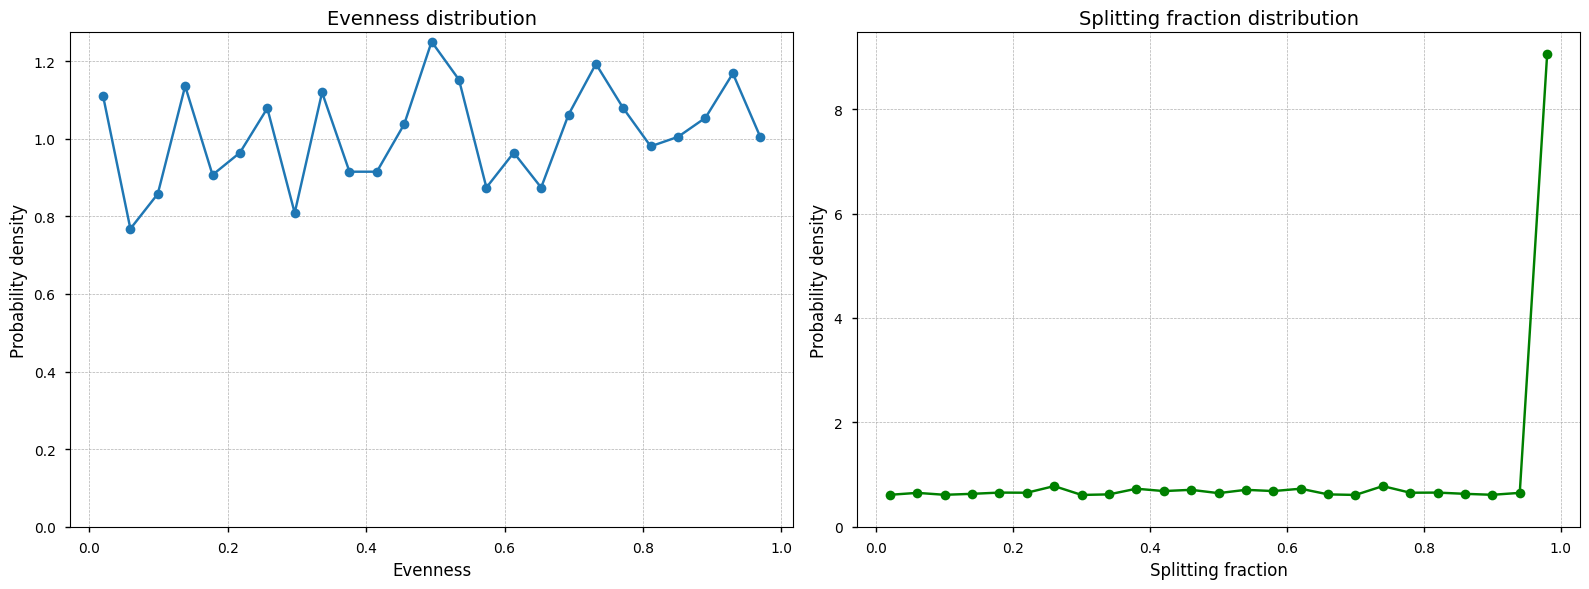

In [225]:
evenness_dist = load_histogram("evenness_dist.dat")
fractions_dist = load_histogram("fractions_dist.dat")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Evenness
if evenness_dist is not None:
    ax1.plot(evenness_dist['q'], evenness_dist['P(q)'], 'o-')
    ax1.set_title('Evenness distribution')
    ax1.set_xlabel('Evenness')
    ax1.set_ylabel('Probability density')
    ax1.set_ylim(bottom = 0)
    ax1.grid(True, ls="--", lw=0.5)
else:
    ax1.set_title('Evenness Data Not Found')

# Plot 2: Fractions
if fractions_dist is not None:
    ax2.plot(fractions_dist['q'], fractions_dist['P(q)'], 'o-', color='green')
    ax2.set_title('Splitting fraction distribution')
    ax2.set_xlabel('Splitting fraction')
    ax2.set_ylabel('Probability density')
    ax2.set_ylim(bottom=0)
    ax2.grid(True, ls="--", lw=0.5)
else:
    ax2.set_title('Fraction Data Not Found')

plt.tight_layout()
plt.show()

## Inlet and outlet coordinates

A simple scatter plot showing the locations of the inlet and outlet nodes.

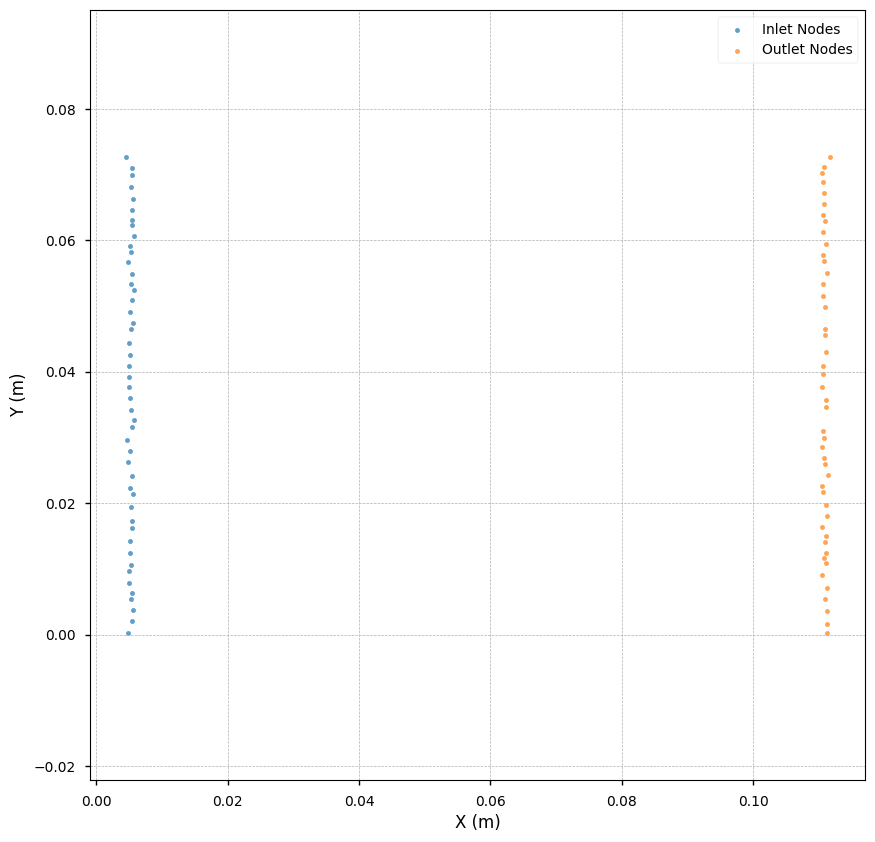

In [226]:
inlet_coords = load_coords("inlet_coordinates.dat")
outlet_coords = load_coords("outlet_coordinates.dat")

if inlet_coords is not None and outlet_coords is not None:
    plt.figure(figsize=(10, 10))
    
    plt.scatter(inlet_coords['x'], inlet_coords['y'], 
                label='Inlet Nodes', s=10, alpha=0.7)
    plt.scatter(outlet_coords['x'], outlet_coords['y'], 
                label='Outlet Nodes', s=10, alpha=0.7)
    
    
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.legend()
    plt.axis('equal') # Ensure aspect ratio is 1:1
    plt.grid(True, ls="--", lw=0.5)
    plt.show()
else:
    print("Skipping coordinate plot: data files not found.")

## Topological layers visualization

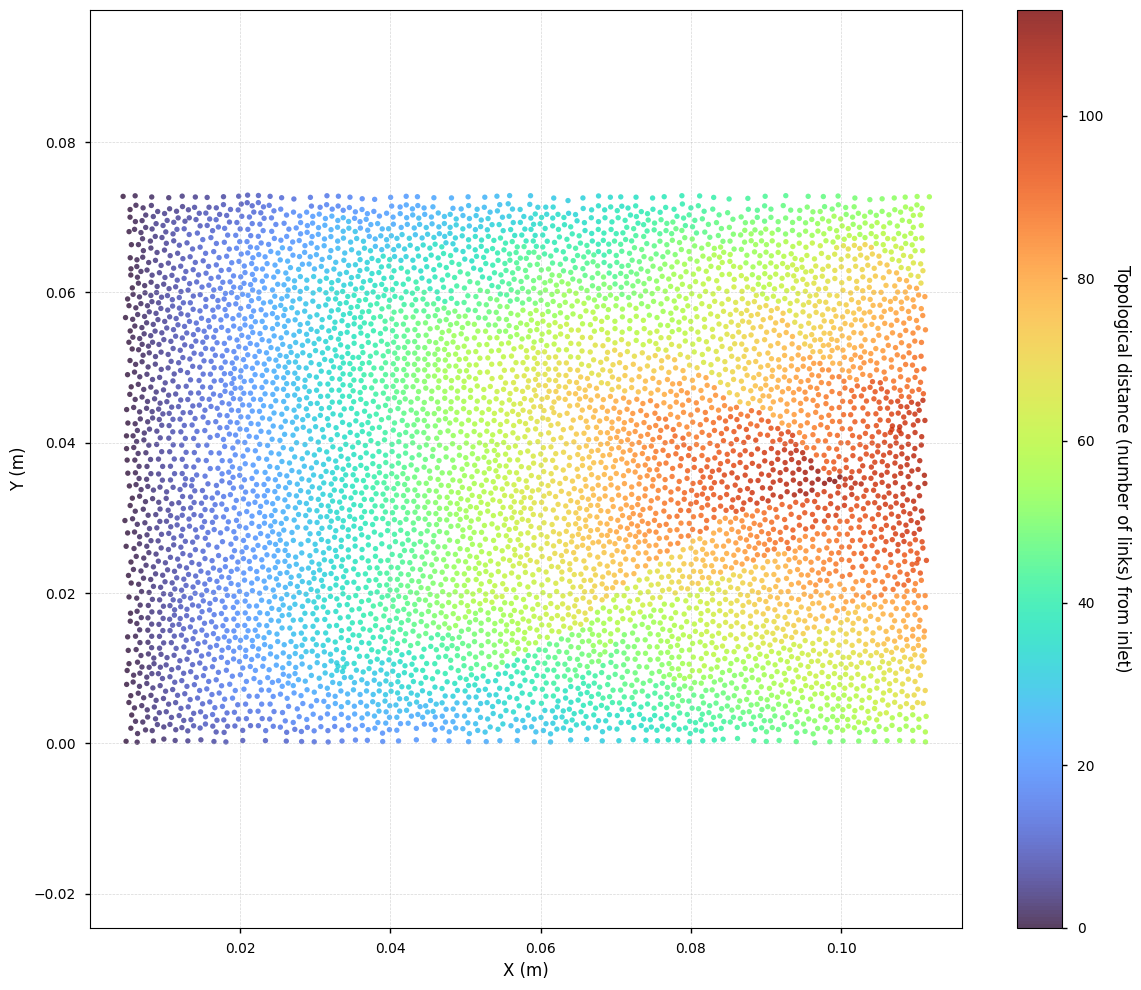

In [227]:
def load_layers_data(filename, path=OUTPUT_DIR):
    filepath = os.path.join(path, filename)
    try:
        # The file is space-separated with a header: "id x y distance"
        data = pd.read_csv(filepath, sep=' ', engine='python')
        return data
    except FileNotFoundError:
        print(f"Warning: File not found: {filepath}")
        return None
    except Exception as e:
        print(f"Warning: Could not load {filepath}. Error: {e}")
        return None

# Load the data
layer_data = load_layers_data("node_layers.dat")

if layer_data is not None:
    plt.figure(figsize=(12, 10))
    
    # Split data into reachable and unreachable nodes
    # (Distance -1 means the node was not reached by the BFS from inlet)
    reachable = layer_data[layer_data['distance'] >= 0]
    unreachable = layer_data[layer_data['distance'] == -1]
    
    # 1. Plot unreachable nodes (if any) in light grey as background
    if not unreachable.empty:
        plt.scatter(unreachable['x'], unreachable['y'], 
                    c='lightgrey', s=10, label='Unreachable', alpha=0.5)

    # 2. Plot reachable nodes colored by distance
    if not reachable.empty:
        # 'turbo' is excellent for depth perception (rainbow-like but perceptually uniform)
        # 'plasma' or 'viridis' are good alternatives
        sc = plt.scatter(reachable['x'], reachable['y'], 
                         c=reachable['distance'], cmap='turbo', 
                         s=15, alpha=0.8, edgecolors='none')
        
        # Add the colorbar to show the distance scale
        cbar = plt.colorbar(sc)
        cbar.set_label('Topological distance (number of links) from inlet)', rotation=270, labelpad=20)
    
    # Graph styling
   
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.xlim(0.00, 0.115)
    plt.ylim(0.01, 0.075)
    
    # Important: Maintain physical aspect ratio
    plt.axis('equal')
    plt.tight_layout()
    
    plt.grid(True, ls='--', lw=0.5, alpha=0.5)
    
    # Only show legend if we have unreachable nodes (to identify the grey dots)
    if not unreachable.empty:
        plt.legend()
        
    plt.show()
else:
    print("Layer data file not found. Make sure you ran the simulation with 'save_node_layers' enabled.")

## Intra-layer statistics (evolution with depth)

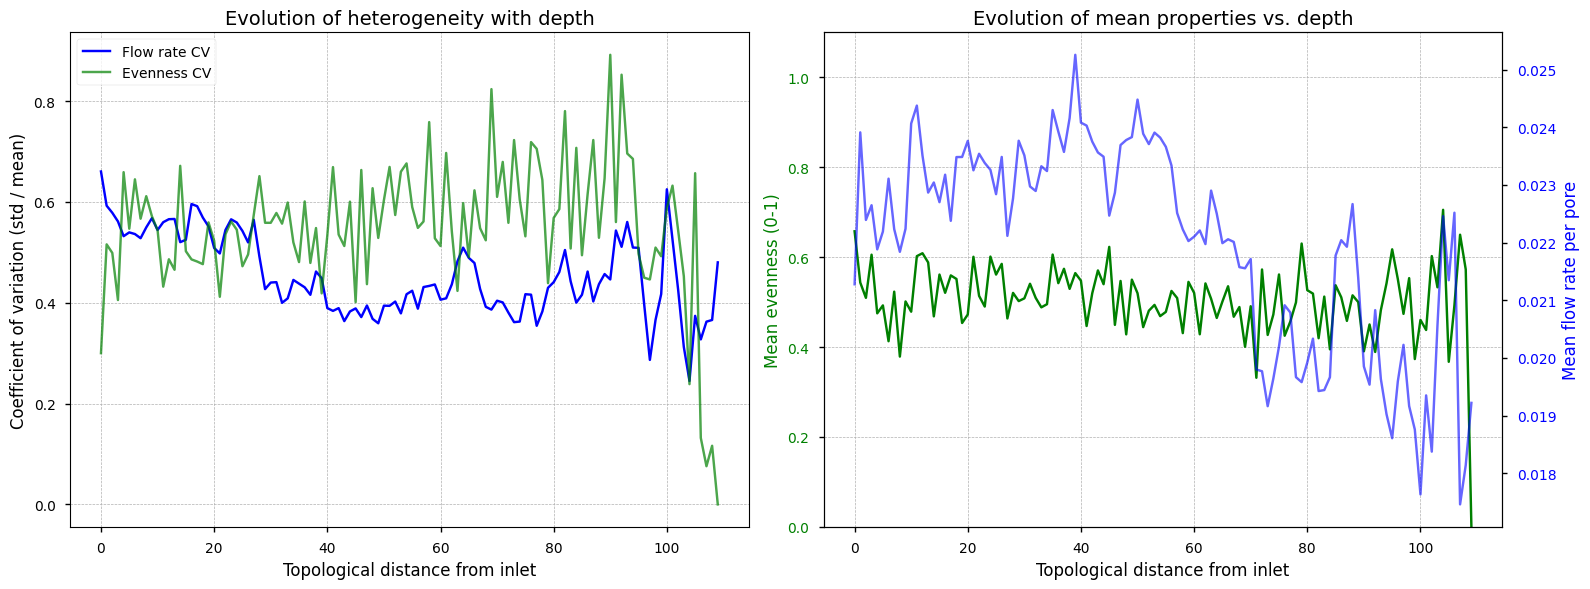

In [228]:
def load_layer_stats(filename, path=OUTPUT_DIR):
    """Loads layer statistics file."""
    filepath = os.path.join(path, filename)
    try:
        # File columns: distance, cv_mass, cv_evenness, mean_mass, mean_evenness
        data = pd.read_csv(filepath, sep='\t', comment='#', header=None,
                           names=['dist', 'cv_mass', 'cv_evenness', 'mean_mass', 'mean_evenness'],
                           engine='python')
        return data
    except FileNotFoundError:
        print(f"Warning: File not found: {filepath}")
        return None
    except Exception as e:
        print(f"Warning: Could not load {filepath}. Error: {e}")
        return None

# Load the data
layer_stats = load_layer_stats("layer_statistics.dat")

if layer_stats is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- Plot 1: Coefficient of Variation (Heterogeneity) ---
    # This measures how "channeled" the flow is within a specific layer
    ax1.plot(layer_stats['dist'], layer_stats['cv_mass'], '-', label='Flow rate CV', color='blue')
    ax1.plot(layer_stats['dist'], layer_stats['cv_evenness'], '-', label='Evenness CV', color='green', alpha=0.7)
    
    ax1.set_title('Evolution of heterogeneity with depth')
    ax1.set_xlabel('Topological distance from inlet')
    ax1.set_ylabel('Coefficient of variation (std / mean)')
    ax1.legend()
    ax1.grid(True, ls='--', lw=0.5)
    
    # --- Plot 2: Mean Values ---
    # We use a secondary y-axis because mass and evenness have different scales
    
    # Left Axis: Evenness
    ax2.plot(layer_stats['dist'], layer_stats['mean_evenness'], '-', color='green', label='Mean evenness')
    ax2.set_ylabel('Mean evenness (0-1)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim(0, 1.1) # Evenness is bounded between 0 and 1
    
    # Right Axis: Mass (Twin Axis)
    ax2_twin = ax2.twinx()
    ax2_twin.plot(layer_stats['dist'], layer_stats['mean_mass'], '-', color='blue', label='Mean Mass', alpha=0.6)
    ax2_twin.set_ylabel('Mean flow rate per pore', color='blue')
    ax2_twin.tick_params(axis='y', labelcolor='blue')
   # ax2_twin.set_yscale('log') # Mass often drops exponentially with depth or stabilizes
    
    ax2.set_title('Evolution of mean properties vs. depth')
    ax2.set_xlabel('Topological distance from inlet')
    ax2.grid(True, ls='--', lw=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print("Layer statistics file not found.")

## Comparative analysis

Generating comparative plots for all available output folders...


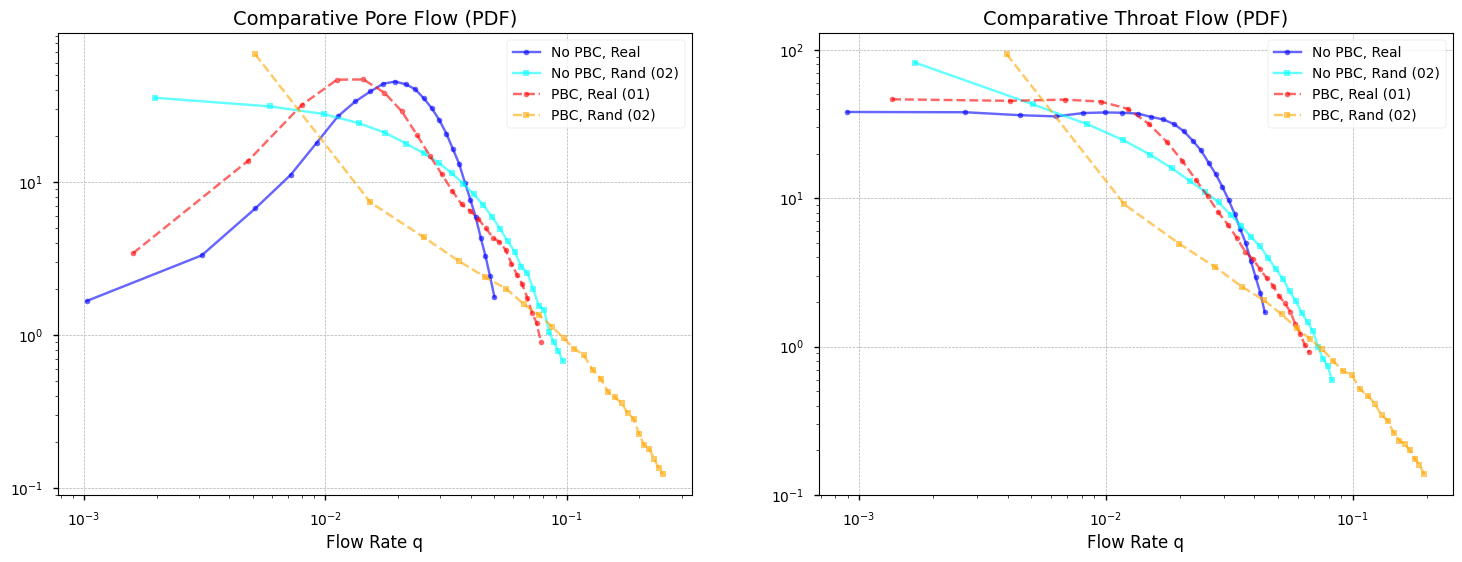

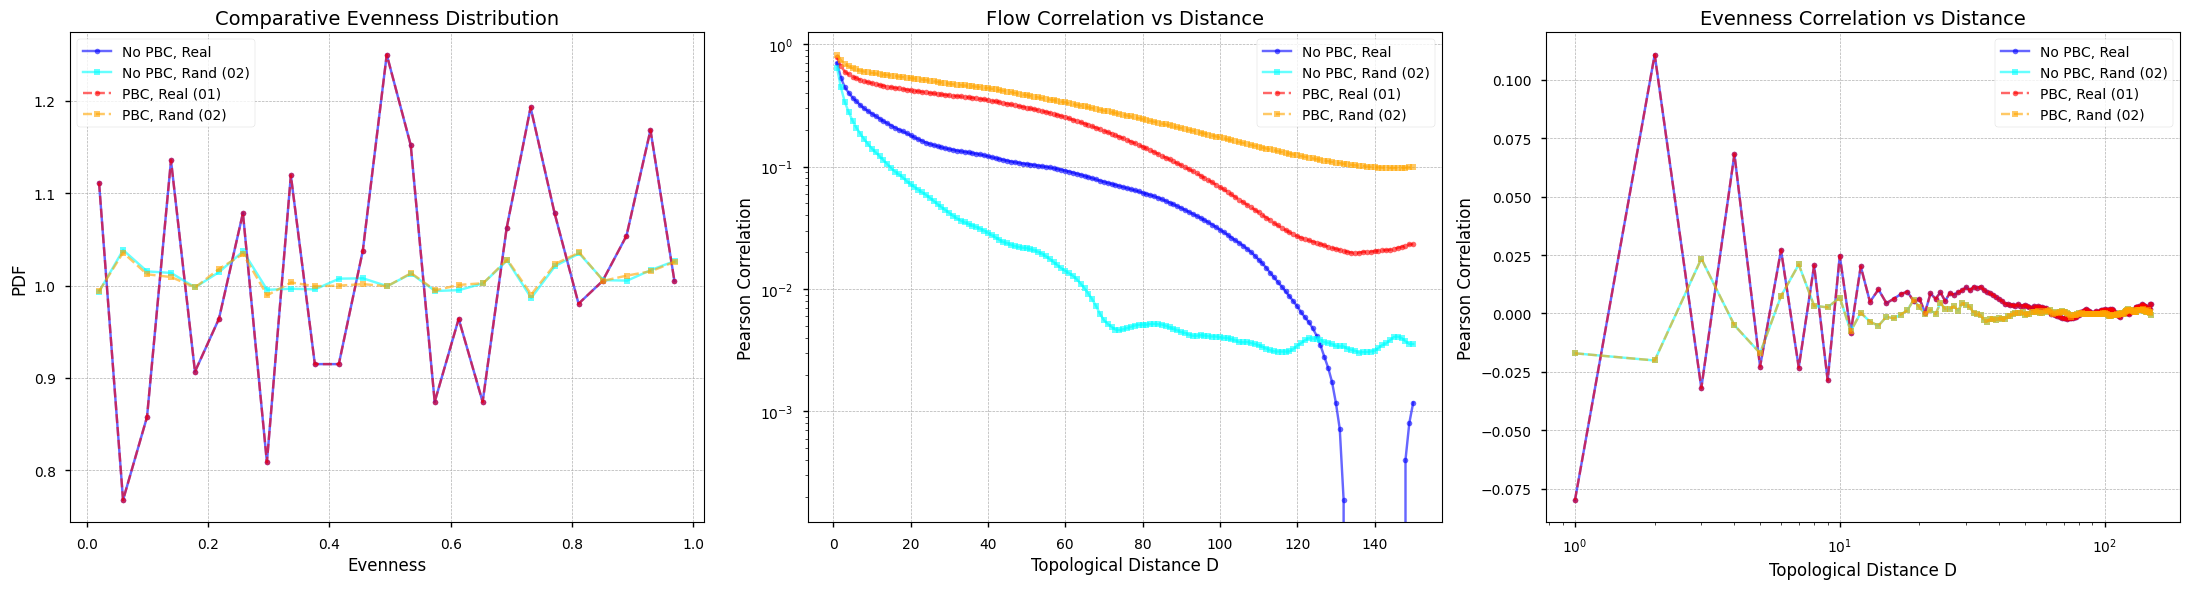

In [ ]:


# Define the 4 cases to look for
cases = [
    {'dir': 'output_01/',      'label': 'No PBC, Real',   'color': 'blue',   'fmt': 'o-'},
    {'dir': 'output_02/',      'label': 'No PBC, Rand (02)',   'color': 'cyan',   'fmt': 's-'},
    {'dir': 'output_PBC_01/',  'label': 'PBC, Real (01)',      'color': 'red',    'fmt': 'o--'},
    {'dir': 'output_PBC_02/',  'label': 'PBC, Rand (02)',      'color': 'orange', 'fmt': 's--'}
]

print("Generating comparative plots for all available output folders...")

# --- Figure 1: Flow Rate Distributions ---
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

for case in cases:
    # Pore Flow
    data = load_histogram("pore_flow_dist.dat", path=case['dir'])
    if data is not None:
        ax1.plot(data['q'], data['P(q)'], case['fmt'], label=case['label'], color=case['color'], markersize=4, alpha=0.6)
    
    # Throat Flow
    data = load_histogram("tube_flow_dist.dat", path=case['dir'])
    if data is not None:
        ax2.plot(data['q'], data['P(q)'], case['fmt'], label=case['label'], color=case['color'], markersize=4, alpha=0.6)

ax1.set_title("Comparative Pore Flow (PDF)")
ax1.set_xlabel("Flow Rate q")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, ls="--", lw=0.5)

ax2.set_title("Comparative Throat Flow (PDF)")
ax2.set_xlabel("Flow Rate q")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, ls="--", lw=0.5)
plt.show()

# --- Figure 2: Evenness & Correlations ---
fig2, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(22, 6))

for case in cases:
    # Evenness Dist
    data = load_histogram("evenness_dist.dat", path=case['dir'])
    if data is not None:
        ax3.plot(data['q'], data['P(q)'], case['fmt'], label=case['label'], color=case['color'], markersize=4, alpha=0.6)

    # Mass Correlation
    data = load_k_data("k_corr_mass.dat", path=case['dir'])
    if data is not None:
        ax4.plot(data['k'], data['value'], case['fmt'], label=case['label'], color=case['color'], markersize=4, alpha=0.6)

    # Evenness Correlation
    data = load_k_data("k_corr_evenness.dat", path=case['dir'])
    if data is not None:
        ax5.plot(data['k'], data['value'], case['fmt'], label=case['label'], color=case['color'], markersize=4, alpha=0.6)

ax3.set_title("Comparative Evenness Distribution")
ax3.set_xlabel("Evenness")
ax3.set_ylabel("PDF")
#ax3.set_yscale('log')
ax3.legend()
ax3.grid(True, ls="--", lw=0.5)

ax4.set_title("Flow Correlation vs Distance")
ax4.set_xlabel("Topological Distance D")
ax4.set_ylabel("Pearson Correlation")
ax4.set_yscale('log')
ax4.legend()
ax4.grid(True, ls="--", lw=0.5)

ax5.set_title("Evenness Correlation vs Distance")
ax5.set_xlabel("Topological Distance D")
ax5.set_ylabel("Pearson Correlation")
ax5.set_xscale('log')
ax5.legend()
ax5.grid(True, ls="--", lw=0.5)

plt.tight_layout()
plt.show()